## Bivariate g-and-k quantile distribution 
#### Braden Scherting
23/02/2019

This notebook implements and performs likelihood-free inference on bivariate g-and-k quantile distributions by use of the novel workflow presented in the accompanying Capstone submission. The implementation depends on the `cnvp.py` module included in the submission. Additionally, up-to-date versions of the packages listed in the import cell are necessary, some of which may require up- or downgraded dependencies.

In [68]:
import os, sys
from functools import partial

import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import elfi
from elfi.examples import bignk, gnk
import torch

# local module
import cnvp

In [69]:
# Fix random state for reproducibility
seed = 992

# Experiment setup, 
n_obs = 20 # M observations
n_reps = 1 # replications
n_sims = 35 # N expensive samples per observation

# Simulation settings
gnk_obs = 10000

In [70]:
np.random.seed(seed)

# Priors used by Drovandi and Pettitt (2011)
# Sample "true" parameters
a1 = ss.uniform.rvs(0, 5, size=n_obs)
a2 = ss.uniform.rvs(0, 5, size=n_obs)
b1 = ss.uniform.rvs(0, 5, size=n_obs)
b2 = ss.uniform.rvs(0, 5, size=n_obs)
g1 = ss.uniform.rvs(-5, 10, size=n_obs)
g2 = ss.uniform.rvs(-5, 10, size=n_obs)
k1 = ss.uniform.rvs(-0.5, 5.5, size=n_obs)
k2 = ss.uniform.rvs(-0.5, 5.5, size=n_obs)

# Parameters used by Drovandi and Pettitt (2011)
# included for comparitive purposes.
a1[0] = 3.0
a2[0] = 4.0
b1[0] = 1.0
b2[0] = 0.5
g1[0] = 1.0
g2[0] = 2.0
k1[0] = 0.5
k2[0] = 0.4

true_params = np.stack((a1,a2,b1,b2,g1,g2,k1,k2), 1)
# print(true_params)

# Generate reproducible "observations" from true parameters
# Deterministic, different seeds to ensure uniqueness/independence
all_obs = np.array([[bignk.BiGNK(a1[i],a2[i],b1[i],b2[i],g1[i],g2[i],k1[i],k2[i],rho=0, n_obs=gnk_obs, 
                            random_state=np.random.RandomState(seed*(i+n_obs)*(j+n_obs))) 
                     for i in range(n_obs)] for j in range(n_reps)])

### Initial and Reference Inference

The following cell compute the initial, crude posteriors for each observation, computes reference solutions, and trains surrogate likelihoods. For an experiment setup with $M$ observations and $R$ replications, it computes $M\times R$ crude posteriors and $M\times R$ reference posteriors. Only $R$ surrogate likelihoods are trained because a single surrogate corresponds to all $M$ observations. To ensure both reproducibility and non-determinism, seeds are transformed between replications/observations. The cell is organized as follows:
- Create empty lists for storing posteriors, evidence points, and surrogates
- For each replication 
    - Create empty dictionary for storing surrogate training data (`out`)
    - For each observation
        - Instantiate the model using ELFI syntax (`m`)
        - Instantiate inference object (`bolfi`) and fit for predefined `n_sims`
        - Collect evidence points from the initial fit (`ev`)
        - Instantiate reference inference object (`bolfi_ref`) and perform full fit
    - Arrange surrogate training data in appropriate format (`out_data`)
    - Instantiate and train conditional real NVP

_BOLFI Settings:_

The bounds of the BOLFI GP are determined by prior ranges. Because parameter ranges are of roughly the same magnitude, acquisition noise variance is held constant across parameters; the value is chosen to encourage exploration (default is 0). Because, given evidence points, the updating of GPs is largely deterministic, the reference solution is obtained by passing `ev` as initial evidence and proceeding with complete inference. 

In [71]:
crude_posts = [] # (n_obs * n_reps) Initial, crude BOLFI fits
ref_posts = [] # (n_obs * n_reps) Full BOLFI fits for reference
local_evidence = [] # (n_obs * n_reps) Acquired evidence from crude to pass to surrogate fits
evidence_keys = ['a1','a2','b1','b2','g1','g2','k1','k2','log_d'] # Evidence to retain

all_nvps = [] # (n_reps) global, surrogate likelihoods
all_out = [] # (n_reps, 8, n_sims*n_obs) training data for surrogates


for j in range(n_reps):
    
    # dictionary for saving simulation queries
    out = {'ss_robust': np.array([]), 'a1': np.array([]), 'a2': np.array([]), 'b1': np.array([]), 
           'b2': np.array([]), 'g1': np.array([]), 'g2': np.array([]), 'k1': np.array([]), 
          'k2': np.array([])}
    
    # Sequential implementation; parallelizable
    for i in range(n_obs):

        # Instatiate model:    
        m = elfi.new_model()
        
        # Priors used by Drovandi and Pettitt (2011)
        priors = []
        priors.append(elfi.Prior('uniform', 0, 5, model=m, name='a1'))
        priors.append(elfi.Prior('uniform', 0, 5, model=m, name='a2'))
        priors.append(elfi.Prior('uniform', 0, 5, model=m, name='b1'))
        priors.append(elfi.Prior('uniform', 0, 5, model=m, name='b2'))
        priors.append(elfi.Prior('uniform', -5, 10, model=m, name='g1'))
        priors.append(elfi.Prior('uniform', -5, 10, model=m, name='g2'))
        priors.append(elfi.Prior('uniform', -.5, 5.5, model=m, name='k1'))
        priors.append(elfi.Prior('uniform', -.5, 5.5, model=m, name='k2'))

        # Different obs, same params per replication
        y_obs = bignk.BiGNK(*true_params[i],rho=0, n_obs=gnk_obs, 
                        random_state=np.random.RandomState(seed*(i+n_obs)*(j+n_reps)))

        # Pass priors to simulator node        
        elfi.Simulator(partial(bignk.BiGNK, rho=0, n_obs=gnk_obs), *priors, observed=y_obs, name='BiGNK')
        
        # Pass simulations to summary node
        # Sumstats proposed by Drovandi and Pettitt (2011)
        elfi.Summary(gnk.ss_robust, m['BiGNK'], name='ss_robust')

        # Pass summaries to discrepancy node
        # Using the custom Euclidean distance function designed for
        # the summary statistics of shape (batch_size, dim_ss, dim_ss_point).
        elfi.Discrepancy(gnk.euclidean_multiss, m['ss_robust'], name='d')
        
        # log-scale discrepancy
        log_d = elfi.Operation(np.log, m['d'], name='log_d')
        
        # the obtuse ELFI storage system
        pool = elfi.OutputPool(['a1','a2','b1','b2','g1','g2','k1','k2','ss_robust','d','log_d'])
        
        # Different BOLFI random_state across reps
        bolfi = elfi.BOLFI(m, target_name='log_d', bounds={'a1':(0,5), 'b1':(0,5), 'g1':(-5,5), 'k1':(-0.5,5), 
                                               'a2':(0,5), 'b2':(0,5), 'g2':(-5,5), 'k2':(-0.5,5)},
                          initial_evidence=20, update_interval=20, acq_noise_var=[0.01,0.01,0.01,0.01,0.01,
                                                                                 0.01,0.01,0.01], pool=pool,
                          seed=seed*(i+n_obs)+1)
        
       
        # Crude BOLFI fit
        bolfi.fit(n_sims)    
        crude_posts.append(bolfi)

        ev = {key: np.array(list(pool.get_store(key).values())).flatten()\
                                   for key in evidence_keys}

        local_evidence.append(ev)

        for key in list(out.keys()):
            out[key] = np.append(out[key], np.array(list(pool.get_store(key).values())).flatten(), axis=0)
        
        # Full BOLFI reference solution; not possible in expensive settings
        # Same settings as above, same first n_sims points
        bolfi = elfi.BOLFI(m, target_name='log_d', bounds={'a1':(0,5), 'b1':(0,5), 'g1':(-5,5), 'k1':(-0.5,5), 
                                               'a2':(0,5), 'b2':(0,5), 'g2':(-5,5), 'k2':(-0.5,5)},
                          initial_evidence=ev, update_interval=20, acq_noise_var=[0.01,0.01,0.01,0.01,0.01,
                                                                                 0.01,0.01,0.01],
                          seed=seed*(i+n_obs)+1)
        
        # Inference does not improve beyond 350 acquisitions
        bolfi.fit(350)
        ref_posts.append(bolfi)

    out_data = np.stack((out['ss_robust'][0::8], out['ss_robust'][1::8], out['ss_robust'][2::8], 
                         out['ss_robust'][3::8], out['ss_robust'][4::8], out['ss_robust'][5::8], 
                         out['ss_robust'][6::8], out['ss_robust'][7::8], out['a1'], out['a2'], 
                         out['b1'], out['b2'], out['g1'], out['g2'], out['k1'], out['k2']), axis=1)
    all_out.append(out_data)

    # Instantiate surrogate
    flow = cnvp.get_nvp(8,8, units=128, mask_depth=3, seed=seed*j)
    
    # Train surrogate
    # More details in cnvp.py
    flow.train_nvp(out_data, batch_size=10, max_epochs=150, val_split=0.1, threshold=25, 
                   lr_step=20, lr_stepsize=0.3)
    all_nvps.append(flow)

We recommend having at least 257 initialization points for the initialization (now 20)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 20)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 20)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 20)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 20)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 20)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 20)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 20)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 20)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 20)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 20)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 20)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 20)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 20)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 20)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 20)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 20)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 20)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 20)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 20)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete
Epoch 1; train loss = 14.763
Epoch 1; val loss = 15.058
Epoch 11; train loss = 8.954
Epoch 11; val loss = 8.661
Epoch 21; train loss = -3.185
Epoch 21; val loss = -1.262
Epoch 31; train loss = -4.022
Epoch 31; val loss = -1.883
Epoch 41; train loss = -6.769
Epoch 41; val loss = -2.039
Epoch 51; train loss = -6.833
Epoch 51; val loss = -2.303
Epoch 61; train loss = -6.833
Epoch 61; val loss = -2.303
Early stop after epoch: 68
Final val loss: -2.303


Can the surrogate match the scale of true simulations? Is there substantial overlap? The next cell quickly checks this. 

In [7]:
all_nvps = []
flow = cnvp.get_nvp(8,8, units=128, mask_depth=3, seed=seed*j)

# Train surrogate
# More details in cnvp.py
flow.train_nvp(out_data, batch_size=10, max_epochs=150, val_split=0.1, threshold=25, 
               lr_step=20, lr_stepsize=0.3)
all_nvps.append(flow)

Epoch 1; train loss = 16.110
Epoch 1; val loss = 14.701
Epoch 11; train loss = 2.710
Epoch 11; val loss = 2.697
Epoch 21; train loss = -4.049
Epoch 21; val loss = -2.886
Epoch 31; train loss = -5.133
Epoch 31; val loss = -3.445
Epoch 41; train loss = -7.208
Epoch 41; val loss = -4.334
Epoch 51; train loss = -7.348
Epoch 51; val loss = -4.363
Epoch 61; train loss = -8.241
Epoch 61; val loss = -4.411
Epoch 71; train loss = -8.330
Epoch 71; val loss = -4.485
Epoch 81; train loss = -8.330
Epoch 81; val loss = -4.485
Epoch 91; train loss = -8.330
Epoch 91; val loss = -4.485
Early stop after epoch: 91
Final val loss: -4.485


[ 0.83994987  1.40206768  1.83633485  1.10446142 -2.322564    1.60512679
  0.78454597  4.56489209]


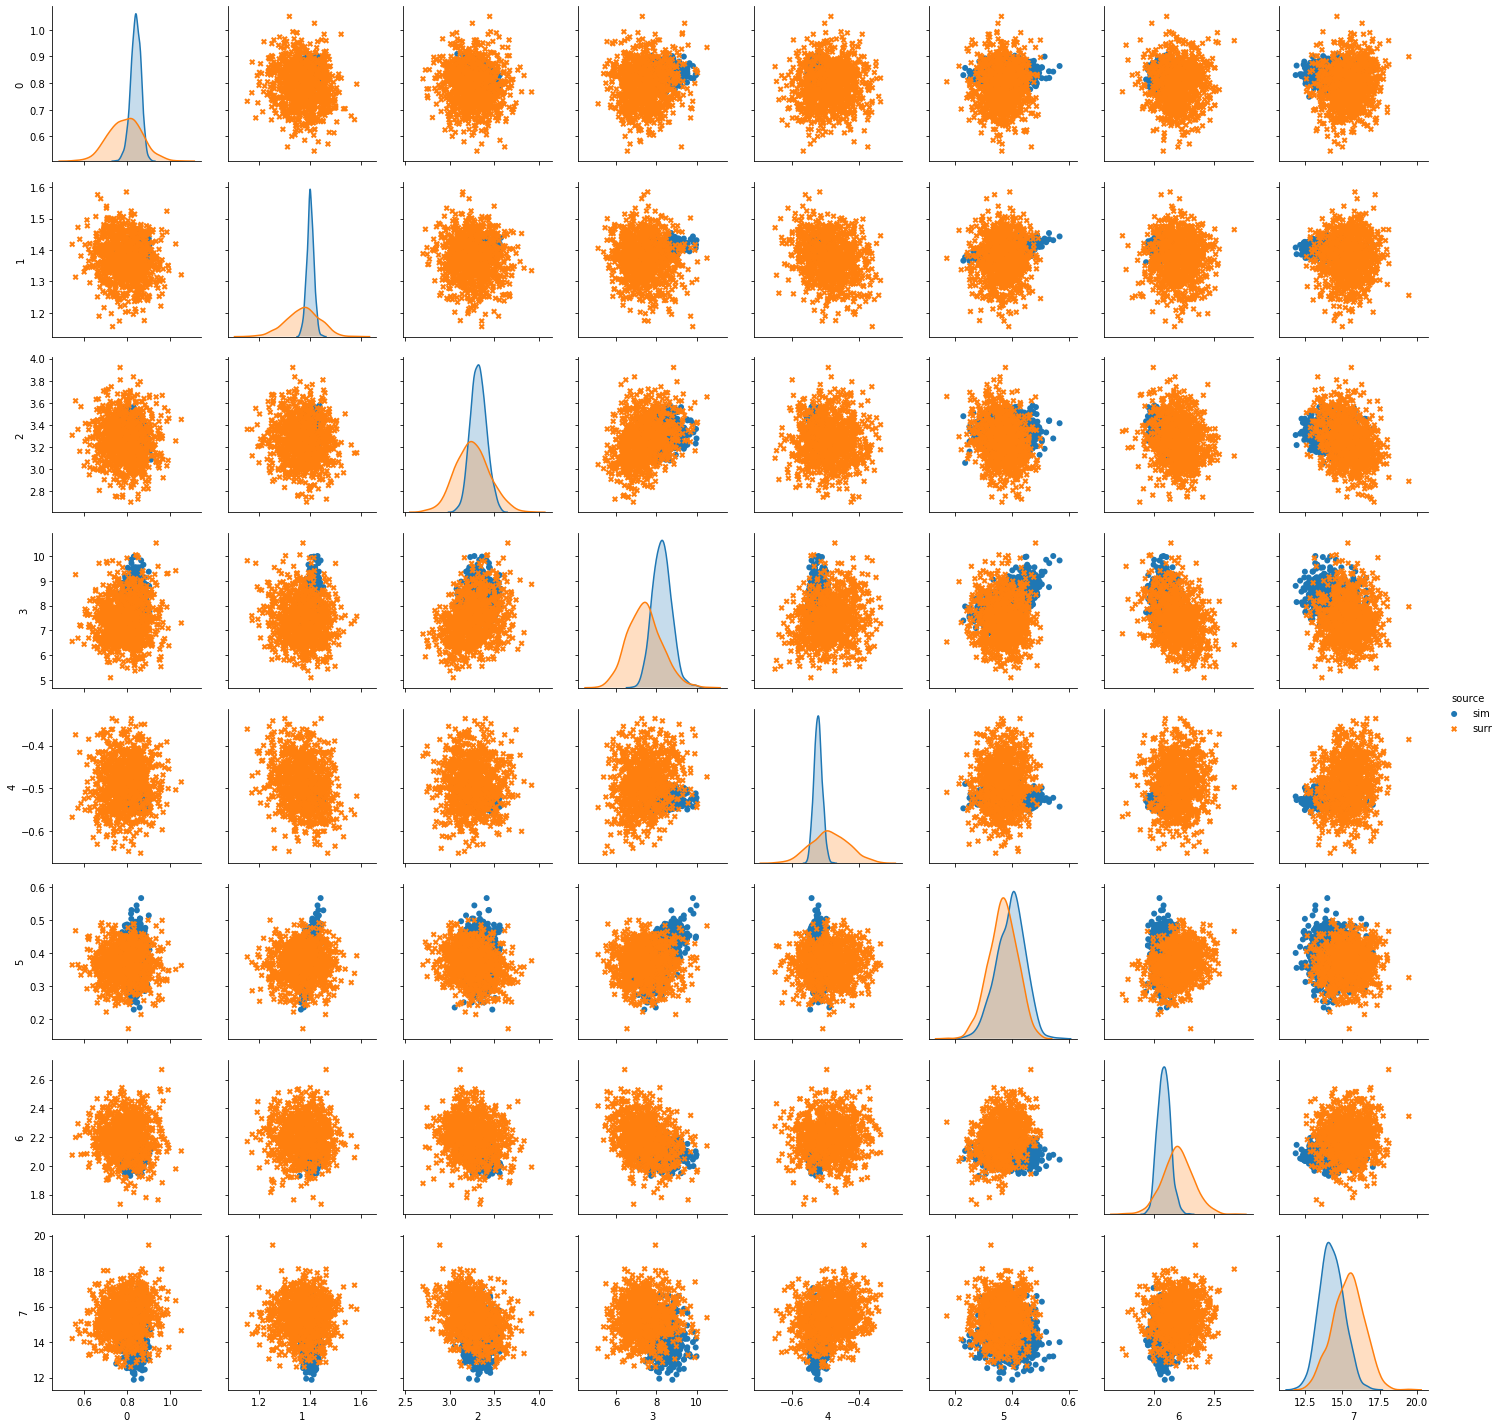

In [54]:
# Visually check surrogate samples (not possible in expensive setting)
theta = true_params[np.random.randint(0,n_obs)] #np.random.randint(0,n_obs)
print(theta)
n_ex = 1000

gnk_samps = gnk.ss_robust(bignk.BiGNK(*theta, rho=n_ex*[0], n_obs=gnk_obs, 
                                      batch_size=n_ex)).reshape(n_ex,1,8)[:,0]
df0 = pd.DataFrame(gnk_samps)
df0.insert(0, 'source', value='sim')

for j in range(n_reps):
    df1 = pd.DataFrame(all_nvps[j].sample(*theta, batch_size=n_ex).detach().numpy()[:,0,:8])
    df1.insert(0, 'source', value='surr')

    df = df0.append(df1)
    sns.pairplot(df, hue="source", markers=["o", "X"], plot_kws=dict(edgecolor="none"))
    
plt.show()

### Simulator-Surrogate Swap

The following cell defines functions with the appropriate keyword arguments to be used in the ELFI pipeline. The first, `surr_sample()`, wraps the `cnvp.py` sampling function, with appropriate arguments for batch computation and reproducibility, and returns data of the appropriate type and shape. The second, `surr_model()`, instantiates a model specific to the surrogate. The most notable difference between this and the model building above is the absence of a summary node. Because the surrogate is an approximation to the density $p(T(y)\mid \theta)$, samples are $T_{\theta}(y)$ and no summarization is necessary. 

In [9]:
# Function for sampling from learned surrogate:
def surr_sample(a1,a2,b1,b2,g1,g2,k1,k2, cnvp, batch_size=1, random_state=None):
    tensor_samp = cnvp.sample(*torch.from_numpy(np.array([a1,a2,b1,b2,g1,g2,k1,k2]).astype(np.float32)), 
                              batch_size=batch_size, random_state=random_state)
    arr_samp = tensor_samp.detach().numpy()
    return arr_samp[:,0,:8].reshape(batch_size, 8, 1)

# ELFI model with surrogate in place of simulator
def surr_model(cnvp, y_obs, seed=None):
    
    m = elfi.new_model()
    
    priors = []
    priors.append(elfi.Prior('uniform', 0, 5, model=m, name='a1'))
    priors.append(elfi.Prior('uniform', 0, 5, model=m, name='a2'))
    priors.append(elfi.Prior('uniform', 0, 5, model=m, name='b1'))
    priors.append(elfi.Prior('uniform', 0, 5, model=m, name='b2'))
    priors.append(elfi.Prior('uniform', -5, 10, model=m, name='g1'))
    priors.append(elfi.Prior('uniform', -5, 10, model=m, name='g2'))
    priors.append(elfi.Prior('uniform', -.5, 5.5, model=m, name='k1'))
    priors.append(elfi.Prior('uniform', -.5, 5.5, model=m, name='k2'))

    # Depends on `surr_samp()` function, but takes arbitrary surrogate
    fn_simulator = partial(surr_sample, cnvp=cnvp)
    elfi.Simulator(fn_simulator, *priors, observed=y_obs, name='surr_sim')
    
    elfi.Discrepancy(gnk.euclidean_multiss, m['surr_sim'], name='d')
    elfi.Operation(np.log, m['d'], name='log_d')
    
    return m

### Completing Local Inference

To complete the local inferences, for each replication and observation we grab a model with the corresponding observation and surrogate, and perform full inference. Each BOLFI object is given the same initial `n_sims` evidence as the crude and reference fits. All other settings are held constant.

In [10]:
# Complete inference after swapping surrogate/simulator

aug_posts = []

for j in range(n_reps):
    for i in range(n_obs):
        y_obs = bignk.BiGNK(*true_params[i],rho=0, n_obs=gnk_obs, 
                        random_state=np.random.RandomState(seed*(i+n_obs)*(j+n_reps)))
        
        # Instantiate surrogate model
        m = surr_model(all_nvps[j], gnk.ss_robust(y_obs))
        bolfi = elfi.BOLFI(m, target_name='log_d', bounds={'a1':(0,5), 'b1':(0,5), 'g1':(-5,5), 'k1':(-0.5,5), 
                                               'a2':(0,5), 'b2':(0,5), 'g2':(-5,5), 'k2':(-0.5,5)},
                          initial_evidence=local_evidence[j*n_obs+i], update_interval=20, 
                          acq_noise_var=[0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01], 
                          seed=seed*(i+n_obs)+3)   
        # Full fit
        bolfi.fit(350)

        aug_posts.append(bolfi)

We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 35)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


### Obtaining Posterior Samples

The following four cells sample from the $3\times M \times R$ GPs generated above. Two diagnostic measures are reported with each posterior sampling run, effective sample size and Rhat. While nearly all pass the diagnostics, samples from the crude samples are decidedly more correlated and the chains are less well-mixed than the reference and augmented samples. This gives some, albeit limited, insight into the natures of each type of posterior. The crude posteriors are broader (slower to traverse) and possibly multi-modal. If we assume that the reference posteriors are converged, then the fact that the augmented sample diagnostics more closely resemble those of reference samples than crude samples suggests convergence of augmented posteriors. 

In [12]:
# Random state handled by seed passed to BOLFI object
# Sample the BOLFI posteriors to obtain posterior samples
def bolfi_sampling(posteriors, n_samps=7500):
    samples = []
    for k in range(len(posteriors)):
        samples.append(posteriors[k].sample(n_samps, algorithm='metropolis', 
                                            sigma_proposals=np.array([0.25,0.25,0.25,0.25,
                                                                      0.5,0.5,0.275,0.275])).samples_array)
        
        if k % 10 == 1:
            print(k)
    return samples

In [13]:
# Sample crude posteriors (dotted line)
crude_samps = bolfi_sampling(crude_posts)

4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
a1 132.14966120456512 1.0072797447023478
a2 94.91091714932475 1.0329668598050004
b1 140.73893070731432 1.0216868596256024
b2 108.20167268696957 1.0617652661190504
g1 173.23493901273082 1.0192702007004109
g2 115.87370862590241 1.0329568032926073
k1 138.3924782319017 1.0081952923269542
k2 160.66350645761884 1.04884068812158
4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
a1 46.594453482784374 1.0629681011282859
a2 123.09793610924017 1.0553616177614762
b1 166.06544142959314 1.020808864164303
b2 156.1529535465155 1.0258536139578882
g1 169.82887989557966 1.017413782567142
g2 112.9198177117119 1.0168171970827329
k1 131.97182688675676 1.0231945789216854
k2 141.2379771263707 1.0109011225988258
1
4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
a1 163.2522354750845 1.0083168433653955
a2 157.16754364864303 1.021004924337134
b1 1

4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
a1 122.70863423959018 1.0254604456231295
a2 113.21218309770174 1.0257568057697444
b1 117.08185720054986 1.0289337246027388
b2 173.7613341309393 1.0150419371692567
g1 97.89505566444579 1.0638958481717116
g2 149.1417956379765 1.0670793458294086
k1 118.63315614619694 1.0175042401758096
k2 136.64450285538493 1.0310066399459386
4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
a1 125.24058287100826 1.0265671969018593
a2 179.5688447947831 1.025216676735522
b1 161.14961196748155 1.0159830837760722
b2 116.03189395920195 1.017925762919609
g1 105.95133235366005 1.00927595672051
g2 112.36087748820869 1.016329251913863
k1 157.84044142213847 1.0184498404241098
k2 107.77356407964979 1.0485292455787203
21
4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
a1 104.31799851739179 1.0596764554786786
a2 133.85796149984913 1.0372209224763511
b

In [14]:
# Sample reference posteriors (solid black)
ref_samps = bolfi_sampling(ref_posts)

4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
a1 475.6160279675525 1.0070410051061147
a2 405.05999315174034 1.008731706392135
b1 387.04112553172774 1.0207697329689527
b2 1061.2560407166748 1.0033328809088404
g1 130.2794139056235 1.0216941561276072
g2 76.26288615629633 1.0525794366683057
k1 711.7842158038981 1.00878183143096
k2 776.4063949868134 1.004149604033622
4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
a1 179.7167723145464 1.023621916227025
a2 199.62365067670558 1.026795846099851
b1 194.5386987832428 1.0076493628752297
b2 433.7409315031408 1.0054579251664508
g1 194.3439416126518 1.0219155396383273
g2 145.6864838344759 1.013826821756065
k1 395.1180857767203 1.0082170247051683
k2 321.7724133434814 1.0052991121531458
1
4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
a1 276.49434595068965 1.0063145866638357
a2 256.16527162643115 1.015014293052682
b1 195.338924

4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
a1 202.69439108335715 1.0196310178852648
a2 150.7095182236972 1.0328866026576216
b1 213.73015334870328 1.0050339745048298
b2 307.6577237974816 1.0134888840705243
g1 141.2201118408384 1.0393080875763967
g2 197.17536077624186 1.0390664811507613
k1 424.5796014168459 1.0024810889238576
k2 387.61192371121604 1.0108536661172052
4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
a1 57.84292423400321 1.049724975915315
a2 153.81290576957386 1.043095056607086
b1 85.86447289034652 1.0534584295406022
b2 417.5296533879033 1.0077331702722836
g1 119.47945699821565 1.0237882363547655
g2 77.21896296309892 1.0309178281504274
k1 207.54582904731885 1.0173495220687965
k2 835.7234694516724 1.002367489897849
21
4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
a1 238.03954914187514 1.030251519225855
a2 214.06880320021222 1.0294012453132309
b1 21

In [15]:
# Sample workflow posteriors (dashed red)
aug_samps = bolfi_sampling(aug_posts)

4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
a1 366.07145977294243 1.004797186664133
a2 335.8869500715106 1.0124916331617135
b1 297.3498928229121 1.0172184405528666
b2 443.66542268724646 1.0030361768469476
g1 22.33212041078161 1.1417199327116752
g2 48.670253610395505 1.0444346290341802
k1 913.2531075808176 1.0028634196116006
k2 643.450492424738 1.0098030598987293
4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
a1 133.87279301221477 1.0309427687919637
a2 163.40219730896894 1.0196670456659973
b1 62.62143543351448 1.0474374643428228
b2 457.25915767873187 1.0155808403970168
g1 70.27061989887706 1.0285794215774444
g2 100.33729018289661 1.0022911150952334
k1 262.4838269124995 1.0209703569164885
k2 387.5779406938849 1.012454288409801
1
4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
a1 245.05856352274753 1.0183206306175978
a2 114.58270060893587 1.0343476501338689
b1 19

4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
a1 217.81555041301905 1.0088248171936454
a2 198.7608543425086 1.0266886407462619
b1 318.2933379217197 1.0103545976983228
b2 448.5274081747168 1.0060921781032723
g1 152.7610744403793 1.0209600005593593
g2 221.12073659215238 1.0101545147930582
k1 567.980260649314 1.0041872983518072
k2 518.1551306414092 1.0038047905556526
4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
a1 77.8296797971356 1.017838549343727
a2 55.53378515435804 1.0536901851647438
b1 47.49938864019134 1.101881598043962
b2 915.3906115197614 1.006858151181433
g1 30.853863228279337 1.0440080439746202
g2 38.167503375725985 1.0496054953729075
k1 257.66128342099597 1.015028217157065
k2 953.6970995917421 1.0052949904864807
21
4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
a1 182.00019306639973 1.0128713508714842
a2 255.9826004597753 1.0090456296461527
b1 238.558

In [16]:
# Plot settings
x_lims = [[-0.5,5.5],[-0.5,5.5],[-0.5,5.5],[-0.5,5.5],
          [-5.5,5.5],[-5.5,5.5],[-1,5.5],[-1,5.5]]

x_ticks = [[0,2.5,5],
           [0,2.5,5],
           [0,2.5,5],
           [0,2.5,5],
           [-5,0,5],
           [-5,0,5],
           [0,2.5,5],
           [0,2.5,5]]


bws = [0.3,0.3,0.3,0.3,0.6,0.6,0.3,0.3]
letters = ['A1','A2','B1','B2','g1','g2','k1','k2']

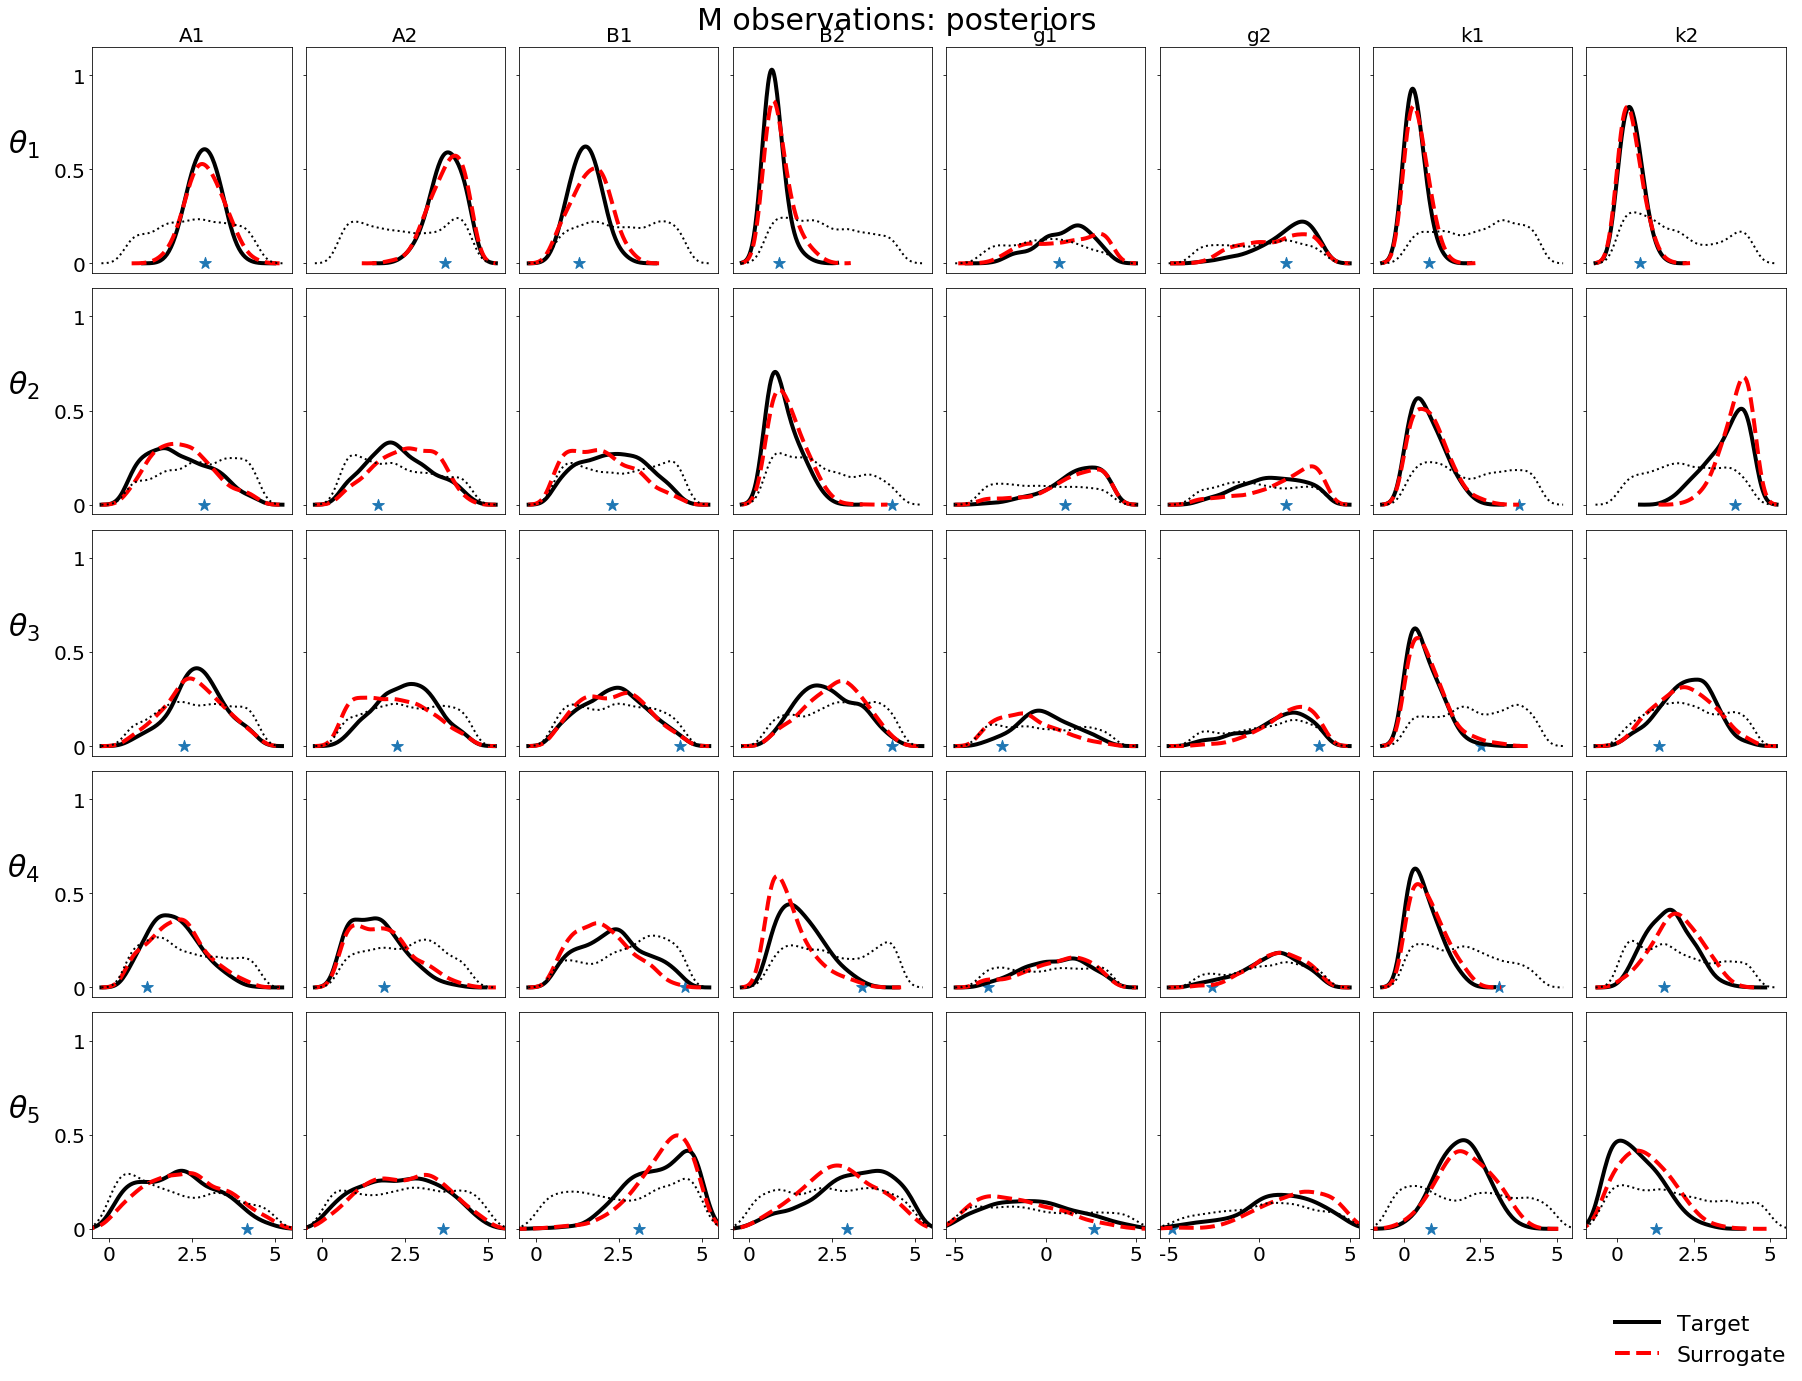

In [82]:
show = 5
fig, axes = plt.subplots(show, 8, sharex=False, sharey=True, figsize=(25,3.5*show))

for j in range(show):
    df0 = pd.DataFrame(crude_samps[j][7500::5])
    df1 = pd.DataFrame(aug_samps[j][7500::5])
    df2 = pd.DataFrame(ref_samps[j][7500::5])
    axes[j,0].set_ylabel(r'$\theta_{ %d }$'%(j+1), rotation=0, fontsize=30)
    axes[j,0].yaxis.labelpad = 30
    
    for i in range(8):
        sns.kdeplot(df2[i], ax=axes[j,i], bw=bws[i], legend=False, color='black', linewidth=4)
        sns.kdeplot(df1[i], ax=axes[j,i], bw=bws[i], legend=False, color='red', linestyle='dashed',linewidth=4)
        sns.kdeplot(df0[i], ax=axes[j,i], bw=bws[i], linestyle='dotted', legend=False, color='black',linewidth=2)

        
        axes[j,i].set_xticks([])
        
        axes[j,i].scatter(true_params[j, i], 0, marker='*', s=150)

    
for ax, col in zip(axes[0], letters):
    ax.set_title(col, fontdict={'fontsize':20})

for ax, lim, tick in zip(axes[-1], x_lims, x_ticks):
    ax.set_xlim(lim)
    ax.set_xticks(tick)
    ax.set_xticklabels(tick,fontsize=20) 

for ax in axes[:,0]:
    ax.set_ylim([-0.05,1.15])
    ax.set_yticks([0,0.5,1])
    ax.set_yticklabels([0,0.5,1],fontsize=20) 

    
fig.tight_layout()
fig.suptitle('M observations: posteriors', fontsize=30, y=1.007)
plt.legend(['Target', 'Surrogate'], loc=(0.1,-0.6), fontsize=22, framealpha=0)

plt.show()

### Sample-free Inference

The following four cells evaluate sample-free inference. The first cell samples new parameters (not from the original "true" parameters). Next, inference is performed on two models, one with full access to the simulator (same as reference posteriors above) and one with access _only to the surrogate._ This differs from the inference performed above in that this raw inference proceeds with zero expensive simulations, whereas the above inference used `n_sims`. All other settings remain the same as above. Both reference and raw posteriors are then sampled, as above, and the results are displayed. 

In [27]:
a1_new = ss.uniform.rvs(0, 5, size=1)
a2_new = ss.uniform.rvs(0, 5, size=1)
b1_new = ss.uniform.rvs(0, 5, size=1)
b2_new = ss.uniform.rvs(0, 5, size=1)
g1_new = ss.uniform.rvs(-5, 10, size=1)
g2_new = ss.uniform.rvs(-5, 10, size=1)
k1_new = ss.uniform.rvs(-0.5, 5.5, size=1)
k2_new = ss.uniform.rvs(-0.5, 5.5, size=1)

new_p = np.stack((a1_new, a2_new, b1_new, b2_new, g1_new, g2_new, k1_new, k2_new), 1)

new_obs = bignk.BiGNK(*new_p[0],rho=0, 
                      n_obs=gnk_obs, random_state=np.random.RandomState(seed))

print(new_p)

[[4.0576241  1.48076354 2.70685022 0.58895561 2.73257501 4.6877874
  1.7119412  3.14265232]]


In [28]:
m = elfi.new_model()

# Priors used by Drovandi and Pettitt (2011)
priors = []
priors.append(elfi.Prior('uniform', 0, 5, model=m, name='a1'))
priors.append(elfi.Prior('uniform', 0, 5, model=m, name='a2'))
priors.append(elfi.Prior('uniform', 0, 5, model=m, name='b1'))
priors.append(elfi.Prior('uniform', 0, 5, model=m, name='b2'))
priors.append(elfi.Prior('uniform', -5, 10, model=m, name='g1'))
priors.append(elfi.Prior('uniform', -5, 10, model=m, name='g2'))
priors.append(elfi.Prior('uniform', -.5, 5.5, model=m, name='k1'))
priors.append(elfi.Prior('uniform', -.5, 5.5, model=m, name='k2'))

# Different obs, same params per replication
y_obs = new_obs

elfi.Simulator(partial(bignk.BiGNK, rho=0, n_obs=gnk_obs), *priors, observed=y_obs, name='BiGNK')

# Sumstats proposed by Drovandi and Pettitt (2011)
# Initialising the default summary statistics.
elfi.Summary(gnk.ss_robust, m['BiGNK'], name='ss_robust')

# Using the customEuclidean distance function designed for
# the summary statistics of shape (batch_size, dim_ss, dim_ss_point).
elfi.Discrepancy(gnk.euclidean_multiss, m['ss_robust'], name='d')

# log-scale discrepancy
log_d = elfi.Operation(np.log, m['d'], name='log_d')

# Different BOLFI random_state across reps
ref_bolfi = elfi.BOLFI(m, target_name='log_d', bounds={'a1':(0,5), 'b1':(0,5), 'g1':(-5,5), 'k1':(-0.5,5), 
                                       'a2':(0,5), 'b2':(0,5), 'g2':(-5,5), 'k2':(-0.5,5)},
                  initial_evidence=25, update_interval=20, acq_noise_var=[0.01,0.01,0.01,0.01,0.01,
                                                                         0.01,0.01,0.01],
                  seed=seed)


# Crude BOLFI fit
ref_bolfi.fit(350)   

m = surr_model(all_nvps[0], gnk.ss_robust(new_obs))
raw_bolfi = elfi.BOLFI(m, target_name='log_d', bounds={'a1':(0,5), 'b1':(0,5), 'g1':(-5,5), 'k1':(-0.5,5), 
                                       'a2':(0,5), 'b2':(0,5), 'g2':(-5,5), 'k2':(-0.5,5)},
                  initial_evidence=25, update_interval=20, 
                  acq_noise_var=[0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01], 
                  seed=seed)   
# Full fit
raw_bolfi.fit(350)

We recommend having at least 257 initialization points for the initialization (now 25)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


We recommend having at least 257 initialization points for the initialization (now 25)


Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [29]:
n_samps = 7500
raw_samps = raw_bolfi.sample(n_samps, algorithm='metropolis', sigma_proposals=np.array([0.25,0.25,0.25,0.25,
                                                                      0.5,0.5,0.25,0.25])).samples_array

ref2_samps = ref_bolfi.sample(n_samps, algorithm='metropolis', sigma_proposals=np.array([0.25,0.25,0.25,0.25,
                                                                      0.5,0.5,0.25,0.25])).samples_array

4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
a1 229.2637489088785 1.011203169130594
a2 175.47267571793506 1.0159202498677147
b1 259.8850209138822 1.0081824527748098
b2 363.2718654589514 1.0103800188430874
g1 100.05905464714549 1.0578793992811018
g2 118.02721753956368 1.0549612024914643
k1 392.1551241831366 1.0039806255245183
k2 318.31126416740244 1.008556012307622
4 chains of 7500 iterations acquired. Effective sample size and Rhat for each parameter:
a1 232.33957683774133 1.0221081145049469
a2 204.65878291316088 1.0178384899969344
b1 287.3383113719245 1.0127489093283206
b2 606.093484225497 1.0033155297816283
g1 123.09568903797117 1.049507577633887
g2 160.3317821524895 1.0416536811488115
k1 424.15099055634073 1.0077419668507615
k2 337.5768326703245 1.0108050703860967


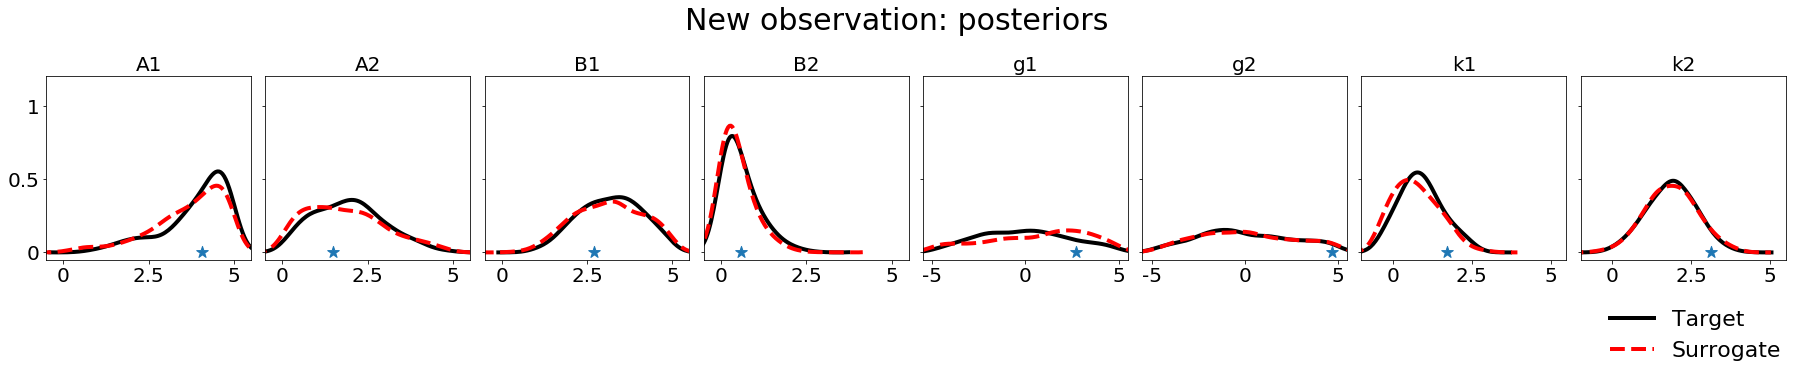

In [30]:
fig, axes = plt.subplots(1, 8, sharex=False, sharey=True, figsize=(25,3.5))

df1 = pd.DataFrame(raw_samps[7500::3])
df2 = pd.DataFrame(ref2_samps[7500::3])

for i in range(8):
    a = sns.kdeplot(df2[i], ax=axes[i], bw=bws[i], legend=False, color='black', linewidth=4)
    b = sns.kdeplot(df1[i], ax=axes[i], bw=bws[i], legend=False, color='red',linestyle='dashed', linewidth=4)


    axes[i].set_xticks([])

    axes[i].scatter(new_p[0,i], 0, marker='*', s=150)
    
for ax, col in zip(axes, letters):
    ax.set_title(col, fontdict={'fontsize':20})

for ax, lim, tick in zip(axes, x_lims, x_ticks):
    ax.set_xlim(lim)
    ax.set_xticks(tick)
    ax.set_xticklabels(tick,fontsize=20) 

for ax in axes:
    ax.set_ylim([-0.05,1.2])
    ax.set_yticks([0,0.5,1])
    ax.set_yticklabels([0,0.5,1],fontsize=20) 


fig.tight_layout()
fig.suptitle('New observation: posteriors', fontsize=30, y=1.15)
plt.legend(['Target', 'Surrogate'], loc=(0.1,-0.6), fontsize=22, framealpha=0)

plt.show()

The following cells are used for computing and reporting 95% credible intervals for each marginal posterior. The printed outputs can be pasted directly into a \tabular environment in a LaTeX editor. The final cell computes and reports the average improvement made by the augmented posteriors. However, the metric used, absolute mean sample error, does not capture higher order moments and thus produces misleading results. These are not included in the paper.  

In [73]:
# Compute relevant percentiles of each thinned sample array
crude_p = np.percentile(np.array(crude_samps[:,7500::5]), q=[2.5, 97.5], axis=1)
ref_p = np.percentile(np.array(ref_samps[:,7500::5]), q=[2.5, 97.5], axis=1)
aug_p = np.percentile(np.array(aug_samps[:,7500::5]), q=[2.5, 97.5], axis=1)

# Obtain CI width by subtraction
crude_ci = crude_p[1] - crude_p[0]
ref_ci = ref_p[1] - ref_p[0]
aug_ci = aug_p[1] - aug_p[0]

In [81]:
# Set parameter table to generate
p = 0

for i in range(n_obs):
    print(f"$\\theta = {true_params[i,p]:.2f} $& \
          ({crude_p[:,i,p][0]:.2f}, {crude_p[:,i,p][1]:.2f}) & \
          ({ref_p[:,i,p][0]:.2f}, {ref_p[:,i,p][1]:.2f}) & \
          ({aug_p[:,i,p][0]:.2f}, {aug_p[:,i,p][1]:.2f}) \\\ ")
print('\\hline')
print(f"Avg width & {crude_ci[:,p].mean():.2f} & {ref_ci[:,p].mean():.2f} & {aug_ci[:,p].mean():.2f} \\\ ")
print(f"Avg Reduction & - & {(crude_ci - ref_ci)[:,p].mean():.2f} & \
{(crude_ci - aug_ci)[:,p].mean():.2f} \\\ ")

$\theta = 0.40 $&           (-0.39, 4.87) &           (-0.47, 1.06) &           (-0.48, 0.98) \\ 
$\theta = 4.23 $&           (-0.32, 4.78) &           (1.95, 4.96) &           (2.62, 4.98) \\ 
$\theta = 1.15 $&           (-0.31, 4.89) &           (0.01, 4.26) &           (-0.14, 4.48) \\ 
$\theta = 1.35 $&           (-0.37, 4.84) &           (-0.05, 3.28) &           (-0.09, 3.57) \\ 
$\theta = 1.25 $&           (-0.37, 4.83) &           (-0.46, 2.54) &           (-0.41, 2.68) \\ 
$\theta = 2.63 $&           (-0.37, 4.82) &           (-0.08, 3.96) &           (0.04, 3.74) \\ 
$\theta = 3.48 $&           (-0.39, 4.86) &           (-0.08, 2.21) &           (-0.23, 2.53) \\ 
$\theta = 2.71 $&           (-0.25, 4.90) &           (0.32, 2.70) &           (-0.02, 2.28) \\ 
$\theta = 1.74 $&           (-0.31, 4.85) &           (2.74, 4.97) &           (2.94, 4.98) \\ 
$\theta = 1.66 $&           (-0.35, 4.88) &           (-0.18, 3.56) &           (0.29, 3.84) \\ 
$\theta = 1.37 $&           

In [62]:
for i in range(n_obs):
    m1 = np.abs(np.mean(crude_samps[i][7500::5] - ref_samps[i][7500::5], 0))
    m2 = np.abs(np.mean(aug_samps[i][7500::5] - ref_samps[i][7500::5], 0))

    # Improvement made by workflow over crude relative to reference
    mean = 100*((m1 - m2) / m1)

    print(f"$p(\\theta_{ {i} } \\mid y_{ {i} } )$& \
    {mean[0]:.2f} &  {mean[1]:.2f} & {mean[2]:.2f} & {mean[3]:.2f} \
    {mean[4]:.2f} &  {mean[5]:.2f} & {mean[6]:.2f} & {mean[7]:.2f} \\\ ")

$p(\theta_{0} \mid y_{0} )$&     91.79 &  98.56 & 87.10 & 91.35     97.47 &  61.40 & 96.78 & 99.00 \\ 
$p(\theta_{1} \mid y_{1} )$&     84.67 &  -203.10 & -51.00 & 87.54     85.79 &  5.41 & 94.86 & 76.38 \\ 
$p(\theta_{2} \mid y_{2} )$&     -353.47 &  -583.00 & 49.28 & 32.35     -484.48 &  -5.73 & 93.23 & 4.14 \\ 
$p(\theta_{3} \mid y_{3} )$&     77.01 &  80.72 & 21.68 & 67.41     86.86 &  -17.99 & 89.14 & 6.56 \\ 
$p(\theta_{4} \mid y_{4} )$&     -6624.49 &  15.67 & 88.60 & 37.26     -164.28 &  -35.96 & 13.26 & 77.56 \\ 
$p(\theta_{5} \mid y_{5} )$&     -75.28 &  64.14 & -146.82 & 59.43     -50.37 &  -488.19 & 83.16 & 75.58 \\ 
$p(\theta_{6} \mid y_{6} )$&     68.79 &  49.74 & 77.50 & 90.55     45.58 &  -34.26 & 93.49 & 99.89 \\ 
$p(\theta_{7} \mid y_{7} )$&     94.18 &  56.62 & -2949.45 & 52.51     33.19 &  89.43 & 78.84 & 64.35 \\ 
$p(\theta_{8} \mid y_{8} )$&     -176.60 &  -152.11 & -17.57 & 18.91     -36.17 &  -29.14 & 83.80 & 97.01 \\ 
$p(\theta_{9} \mid y_{9} )$&     84.30 &  3